In [1]:
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import sys
import os
import seaborn as sb
from IPython.display import HTML
from IPython import display
from ipywidgets import FloatSlider
from scipy.integrate import odeint
from scipy.interpolate import interp1d
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['figure.dpi'] = 120

In [2]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/Shareddrives/Dollar Research Group/Scripts_and_Code/Protons')

Mounted at /content/drive


In [ ]:
!pwd

/content/drive/Shareddrives/Dollar Research Group/Scripts_and_Code/Protons


In [3]:
## define constants, density

# Polyethylene terephthalate density (g/cm^3)
polydens = 1.38
# Aluminum density (g/cm^3)
Aldens = 2.7
# Iron density (g/cm^3)
Fedens = 7.874
# Polyethylene thickness in um
polythickness = 105
spacerthickness = 1550

In [4]:
# Import stopping power from file

######### POLYETHYLENE TEREPHTHALATE (MYLAR)
datapoly = np.genfromtxt('poly.txt', delimiter=' ', skip_header=8, usecols=(0, 1, 2))
# Convert columns to a NumPy array
KEpoly = np.array(datapoly[:,0])
SPpoly = np.array(datapoly[:,1]) * polydens # mulitply by density to get SP in MeV/cm
#CSDApoly = np.array(datapoly[:,2])

SPpoly_int = interp1d(KEpoly, SPpoly, kind='cubic')

######## ALUMINUM
dataAl = np.genfromtxt('al.txt', delimiter=' ', skip_header=8, usecols=(0, 1, 2))
# Convert columns to a NumPy array
KEAl = np.array(dataAl[:, 0])
SPAl = np.array(dataAl[:, 1]) * Aldens
#CSDAAl = np.array(dataAl[:, 2])

SPAl_int = interp1d(KEAl, SPAl, kind='cubic')

######## IRON
dataFe = np.genfromtxt('fe.txt', delimiter=' ', skip_header=8, usecols=(0, 1, 2))
# Convert columns to a NumPy array
KEFe = np.array(dataFe[:, 0])
SPFe = np.array(dataFe[:, 1]) * Fedens
#CSDAFe = np.array(dataFe[:, 2])

SPFe_int = interp1d(KEFe, SPFe, kind='cubic')

In [5]:
## Input stack params, proton energy, returns stopping distance

def stack_stop(stack, energy, dx = 0.001):
  e = energy
  stopping_dist = 0
  d = 0
  de = 0
  # calculate energy loss one layer in the stack at a time
  for layer in stack:
    if layer[0] == "poly":
      int_fn = lambda x: SPpoly_int(x)
    if layer[0] == "Al":
      int_fn = lambda x: SPAl_int(x)
    if layer[0] == "Fe":
      int_fn = lambda x: SPFe_int(x)
     # int_fn = lambda x: SPpoly_int(x)
    d = 0
    # Euler method to track proton energy. Stops when proton stops or gets to the next layer
    while not(de > e or e < 0.001 or d >= layer[1]):
      d += dx
      de = dx * int_fn(e)[()]
      e -= de
    stopping_dist += d

  return stopping_dist

In [99]:
## Input stack params, list of energies, return array of stopping distances
## **********

def energy_bands(stack, energies, dx=0.001):
  stop = []
  total = np.sum([i[1] for i in stack])

  for en in energies:
    ss = stack_stop(stack, en, dx)
    if ss >= total:
      break
    stop.append([ss])
  return stop

In [7]:
## Input stack params, energy array, and stopping distance array. Plot stopping ranges for RCF stack
# *********
def plot_bands(stack, energies, bands, show_layers=False, name=""):
  x = np.array([i[0] * 10**4 for i in bands])
  y = energies[:len(bands)]
  stackdims = np.array([i[1] for i in stack])
  endpoints = [np.sum(stackdims[:i]) * 10**4 for i in range(len(stackdims)+1)]
  fig, ax = plt.subplots()

  for i in range(len(endpoints)-1):
    if stack[i][0] == "Al":
      col = "gray"
    elif stack[i][0] == "Fe":
      col = "green"
    elif stack[i][0] == "poly":
      col = "orange"
    ax.fill_betweenx(y, endpoints[i], endpoints[i+1], color=col)
    if show_layers: fig.text(0.92, 0.8 - 0.05*i, '{}'.format(stack[i]))

  ax.scatter(x, y, color='black')
  ax.set_xlabel('Range [$\mu$m]', fontsize =12)
  ax.set_ylabel('Energy [MeV]',fontsize=12)
  ax.set_title('Stopping range for {}'.format(name if name != "" else 'stack'))

In [100]:
## Input stack, energies, and stopping distance array, return energy ranges for each layer

def energy_bins(stack, energies, bands):
  intfn = interp1d(np.array(bands).reshape([len(bands),]), energies[:len(bands)], kind='cubic')
  thicks = np.array(stack)[:,1].astype(float) # Convert thicknesses to float
  cs = np.append([0],np.cumsum(thicks))
  for i in range(len(stack)):
    if i == 0:
      emin=0
    else:
      emin = intfn(cs[i])
    if i == len(stack) - 1:
      emax = energies[-1]
    else:
      emax = intfn(cs[i+1])
    print('Layer', i+1, 'bin is', emin,'-',emax)

In [101]:
energy_bins(stack_1, en, bands_1)

1
Layer 1 bin is 0 - 0.8753364249901555
Layer 2 bin is 0.8753364249901555 - 1.2947808321872099
Layer 3 bin is 1.2947808321872099 - 3.139300368400709
Layer 4 bin is 3.139300368400709 - 3.2416153337346376
Layer 5 bin is 3.2416153337346376 - 3.438210597230366
Layer 6 bin is 3.438210597230366 - 11.0


In [96]:
active = 0.0007
stack_2 = [["Al", 0.0025]]
for i in range(3):
  stack_2.append(["Fe",active])
  stack_2.append(["poly", (polythickness / np.power(10,4))-active])
#stack_2.append(["Al", 1500 / np.power(10,4)])
#for i in range(20): stack_2.append(["poly", polythickness / np.power(10,4)])
#stack_2

In [56]:
stack_1 = [['Al', 0.0012],['poly', 0.0012],['poly',0.0097],['Fe', 0.0003],['poly', 0.0012],['poly',0.0097]]

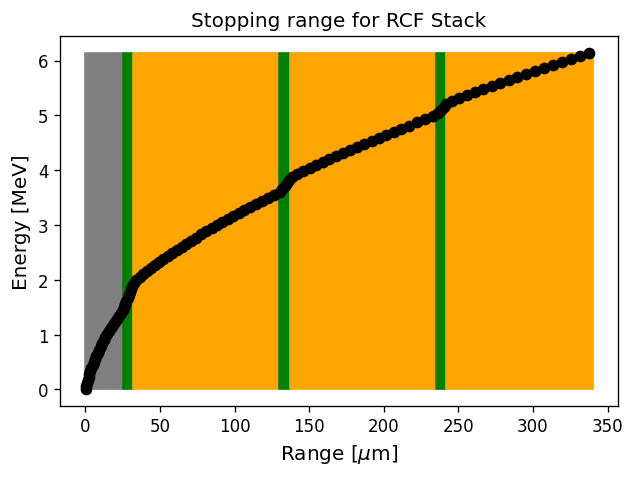

In [104]:
en = np.linspace(0.01, 11, 200)
bands_2 = energy_bands(stack_2, en, dx=0.000001)
plot_bands(stack_2, en, bands_2, name = "RCF Stack")

In [105]:
energy_bins(stack_2, en, bands_2)

1
Layer 1 bin is 0 - 1.427748357404821
Layer 2 bin is 1.427748357404821 - 1.921264608592766
Layer 3 bin is 1.921264608592766 - 3.589153350488052
Layer 4 bin is 3.589153350488052 - 3.839744352002997
Layer 5 bin is 3.839744352002997 - 5.006463277828281
Layer 6 bin is 5.006463277828281 - 5.20178250081202
Layer 7 bin is 5.20178250081202 - 11.0


In [ ]:
stack_3 = [["Al", 0.00125]]
for i in range(66): stack_3.append(["poly", polythickness / np.power(10,4)])
#stack_2.append(["Al", 1500 / np.power(10,4)])
#for i in range(20): stack_2.append(["poly", polythickness / np.power(10,4)])
#stack_2

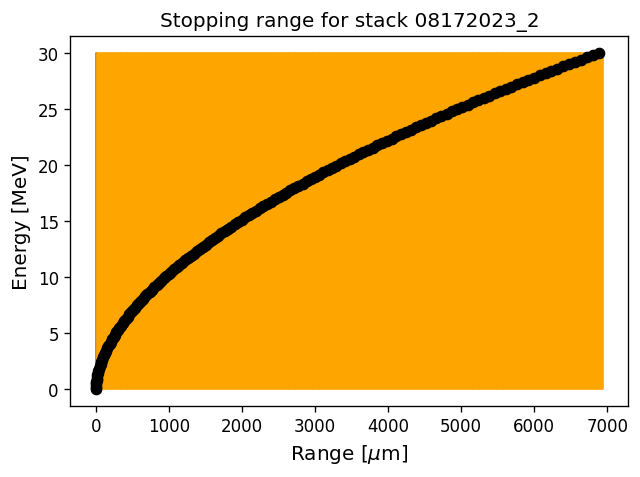

In [ ]:
en = np.linspace(0.01, 30, 150)
bands_3 = energy_bands(stack_3, en, dx=0.00001)
plot_bands(stack_3, en, bands_3, name = "stack 08172023_2")

In [ ]:
energy_bins(stack_3, en, bands_3)

Layer 1 bin is 0 - 0.9028853673077185
Layer 2 bin is 0.9028853673077185 - 3.091300558795878
Layer 3 bin is 3.091300558795878 - 4.423536494748805
Layer 4 bin is 4.423536494748805 - 5.496426050653629
Layer 5 bin is 5.496426050653629 - 6.425861437701551
Layer 6 bin is 6.425861437701551 - 7.258928387073181
Layer 7 bin is 7.258928387073181 - 8.021910258697096
Layer 8 bin is 8.021910258697096 - 8.73117761173865
Layer 9 bin is 8.73117761173865 - 9.397472394315459
Layer 10 bin is 9.397472394315459 - 10.027664619099722
Layer 11 bin is 10.027664619099722 - 10.627420980585706
Layer 12 bin is 10.627420980585706 - 11.201251933659849
Layer 13 bin is 11.201251933659849 - 11.752210582132507
Layer 14 bin is 11.752210582132507 - 12.283309213434748
Layer 15 bin is 12.283309213434748 - 12.7963582023412
Layer 16 bin is 12.7963582023412 - 13.293227896376806
Layer 17 bin is 13.293227896376806 - 13.775663917177654
Layer 18 bin is 13.775663917177654 - 14.244732876388362
Layer 19 bin is 14.244732876388362 - 14.